In [2]:
import sys
import os
import numpy as np
import pickle
import shap
from tqdm import tqdm
from collections import OrderedDict
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sn

sys.path.append('../')
from datasets.data_loader import get_loaders
from util.xai_utils import *
import utils

### Configuration

In [45]:
base_model_path = f'../../results/intra_edge-iot_scratch/models/task0-1728752339941823.ckpt'
args_path = '../../results/intra_edge-iot_scratch/args-1728752339941823.txt'

### Utils

In [46]:
def get_appr_params(base_path, T=2, scratch=False):
    dict_appr_params  = {} 
    alpha, beta = None, None
    results_files = [elem for elem in glob(f'{base_path}/results/*') if (('outputs_targets_features_' in elem) \
                        and elem.split('/')[-1].split('-')[0].split('_')[-1]=='1')]
    if len(results_files)==0:
        results_files = [elem for elem in glob(f'{base_path}/results/*') if 'per_class_metrics' in elem]    
    if scratch:
        results_files = glob(f'{base_path}/results/*')
        print(results_files)
        results_files = [x for x in results_files if 'output' in x and 'class' not in x and 'episode' not in x]
    for out_path in results_files:    
        timestamp = out_path.split('.')[0].split('-')[-1].split('_')[0]
        args_file = f'{base_path}/args-{timestamp}.txt'
        stdout_file = f'{base_path}/stdout-{timestamp}.txt'
        with open(stdout_file) as f:
            lines = f.readlines()
        with open(args_file) as f:
            args = Box(json.loads(f.read()))
        t = int(args.get('T', default = 2))

        if t==T:
            for l in lines:
                if 'Class order' in l:
                    class_order = [int(elem) for elem in l.split(':')[-1].replace('[','').replace(']','').replace('','').split(',')]
                    
                if 'BiC training for Task 1' in l:
                    alpha=float(l.split('alpha=')[-1].split(',')[0])
                    beta=float(l.split('beta=')[-1])
            dict_appr_params[args.seed]={'alpha':alpha, 'beta':beta, 
                'timestamp':timestamp, 'class_order':class_order}
    return dict_appr_params  

In [47]:
device = torch.device('cpu')

class scratch(nn.Module):
    def __init__(self):
        super(scratch, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(4,2), stride=(1,1), padding=0)
        self.relu1 = nn.ReLU()
        self.max1 = nn.MaxPool2d((3,2), (1,1), 0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(4,2), stride=(1, 1), padding=0)        
        self.max2 = nn.MaxPool2d((3,1), stride=(1,1), padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(10*4*64,200)        
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 14)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.pad(x, (0, 1) + (1, 2))
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.pad(x, (0, 1) + (1, 1))
        x = self.max1(x)
        x = self.bn1(x)
        x = F.pad(x, (0,1) + (1,2))
        x = self.conv2(x)
        x = self.relu2(x)
        x = F.pad(x, (0,0) + (1,1))
        x = self.max2(x)
        x = self.bn2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
scratch_model = scratch().to(device)

#load trained model
base_model = torch.load(base_model_path, map_location=torch.device('cpu'))

base_model['model.fc2.weight'] = base_model['heads.0.weight']
del base_model['heads.0.weight']

base_model['model.fc2.bias'] = base_model['heads.0.bias']
del base_model['heads.0.bias']

base_model2 = OrderedDict()

for k in base_model.keys():
    base_model2['.'.join(k.split('.')[1:])] = base_model[k]

scratch_model.load_state_dict(base_model2)
scratch_model.eval()

scratch(
  (conv1): Conv2d(1, 32, kernel_size=(4, 2), stride=(1, 1))
  (relu1): ReLU()
  (max1): MaxPool2d(kernel_size=(3, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2560, out_features=200, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=200, out_features=14, bias=True)
  (softmax): Softmax(dim=1)
)

### Load Inputs

In [48]:
with open(args_path) as f:
    args = Box(json.loads(f.read()))

print(f'{args.seed=}')
utils.seed_everything(seed=args.seed)
trn_loader, val_loader, tst_loader, taskcla = get_loaders(
        args.datasets, args.num_tasks, args.nc_first_task, args.nc_incr_tasks, args.batch_size,
        validation=0.1, num_workers=0, num_pkts=args.num_pkts, fields=args.fields,
        seed=args.seed
    )

args.seed=1
Index(['SCALED_PL', 'SCALED_IAT', 'SCALED_DIR', 'SCALED_WIN', 'ENC_LABEL',
       'IS_TRAIN'],
      dtype='object')
Class order:  [2, 12, 1, 6, 9, 10, 7, 11, 3, 5, 13, 0, 8, 4]


In [49]:
trn_instances_scratch = np.concatenate([x for x, y in trn_loader[0]], axis=0)
tst_instances_scratch = np.concatenate([x for x, y in tst_loader[0]], axis=0)
tst_targets_scratch = np.concatenate([y for x, y in tst_loader[0]], axis=0)
trn_instances = torch.from_numpy(trn_instances_scratch)
tst_instances = torch.from_numpy(tst_instances_scratch)
class_order_scratch = [2, 12, 1, 6, 9, 10, 7, 11, 3, 5, 13, 0, 8, 4]
tst_targets_true = [class_order_scratch[elem] for elem in tst_targets_scratch]
logits_scratch = scratch_model(tst_instances)
pred_scratch = [np.argmax(elem.detach().numpy()) for elem in logits_scratch]
pred_scratch_true = [class_order_scratch[elem] for elem in pred_scratch]
argsort_scratch=np.argsort(class_order_scratch)

### Select Samples

In [50]:
backd_http_conf = {}
ransom_http_conf = {}

backd_http_conf[0] = np.array(np.where((np.array(tst_targets_true)==11) & (np.array(pred_scratch_true)==8))[0])
backd = np.array(np.where((np.array(tst_targets_true)==11))[0])

ransom_http_conf[0] = np.array(np.where((np.array(tst_targets_true)==13) & (np.array(pred_scratch_true)==8))[0])
ransom = np.array(np.where((np.array(tst_targets_true)==13))[0])

print(f'[INFO] Backdoor-TCP instances confused with injection-http: {len(backd_http_conf[0])*100/len(backd)}')
print(f'[INFO] Ransomware instances confused with injection-http: {len(ransom_http_conf[0])*100/len(ransom)}')

outdir = './shap/'
os.makedirs(outdir, exist_ok=True)

with open(os.path.join(outdir, 'backd_http_conf.pickle'), 'wb') as fp:
    pickle.dump(backd_http_conf, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(outdir, 'ransom_http_conf.pickle'), 'wb') as fp:
    pickle.dump(ransom_http_conf, fp, protocol=pickle.HIGHEST_PROTOCOL)


[INFO] Backdoor-TCP instances confused with injection-http: 96.29629629629629
[INFO] Ransomware instances confused with injection-http: 94.44444444444444


### SHAP

In [51]:
for fn, name in zip(['backd_http_conf', 'ransom_http_conf'],
                ['backd_http_confused', 'ransom_http_confused']):

    with open(os.path.join(outdir, f'{fn}.pickle'), 'rb') as dic:
        idx_dict = pickle.load(dic) 
    
    target_class = 0
    index=np.arange(len(trn_instances))
    random_index=np.random.choice(index, 5, replace=False)
    
    trn_instances_bkg = torch.from_numpy(np.array(trn_instances))[random_index]
    idxs = idx_dict[target_class]
    print(f'[INFO] Explaining {len(idxs)} samples!')
    background = trn_instances_bkg
    
    e = shap.DeepExplainer(scratch_model, background)

    shap_values_bic = e.shap_values(tst_instances[idxs])

    shap_filename=f'shap_values_{name}_seed{args.seed}_5r_deepExplainer.pickle'

    output = open(shap_filename, 'wb')
    pickle.dump(shap_values_bic, output)
    output.close()


[INFO] Explaining 26 samples!
[INFO] Explaining 17 samples!


### Plot

#### backd

In [52]:
bic=[]
target_class=11
confused_class=8
details = False
idxs = np.where((np.array(tst_targets_true)==target_class) & (np.array(pred_scratch_true)==confused_class))[0]
idx_target_class = np.where(np.array(tst_targets_true)==target_class)[0]

shap_filename=f'shap_values_backd_http_confused_seed1_5r_deepExplainer.pickle'

with open(shap_filename, 'rb') as shap_f:
    shap_values_bic = pickle.load(shap_f)    
    
for indice_shap in tqdm(np.arange(len(idxs))):
    bic.append(shap_values_bic[argsort_scratch[confused_class]][indice_shap][0]/(np.sum(shap_values_bic[argsort_scratch[confused_class]][indice_shap])))

100%|██████████| 26/26 [00:00<00:00, 79833.02it/s]


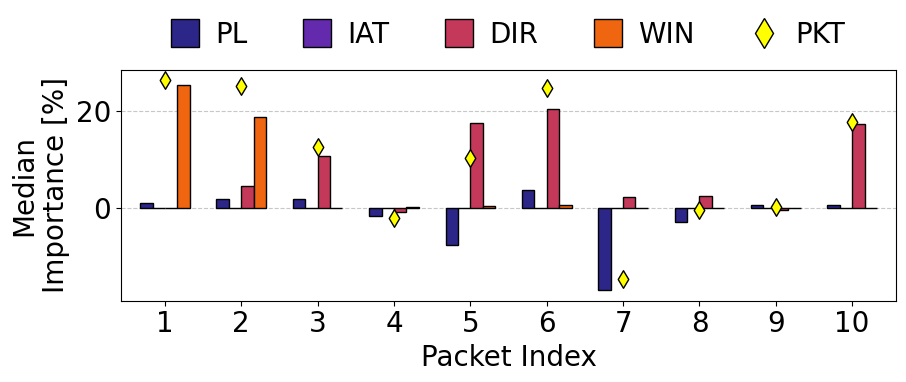

In [53]:
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(10,3))
bic_sum = np.sum(np.reshape(np.median(bic, axis=0)*100,(10,4)),axis=1)
df=pd.DataFrame(data=np.reshape(np.median(bic, axis=0)*100,(10,4)), columns=['PL', 'IAT', 'DIR', 'WIN'])
df.plot.bar(edgecolor='black', width=0.65, ax=axes, legend=False, color=sn.color_palette('CMRmap'))
axes.legend(bbox_to_anchor= (0.89, 2.45, 0., 0.), ncols=4, frameon=False, handlelength=1.2)
axes.set_xlabel('Packet Index')
axes.set_xticklabels([str(x+1) for x in np.arange(10)], rotation=0)
axes.scatter(np.arange(10),bic_sum, color='yellow', s=80, marker='d', edgecolor='black')
axes.grid(axis='y', linestyle='--', alpha=0.7)
axes.set_axisbelow(True)
axes.set_ylabel(r'Median' + '\n' + 'Importance [%]')

legend_elements = [Line2D([0], [0], marker='s', color='w', label='PL',
                          markerfacecolor=sn.color_palette('CMRmap')[0], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='IAT',
                          markerfacecolor=sn.color_palette('CMRmap')[1], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='DIR',
                          markerfacecolor=sn.color_palette('CMRmap')[2], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='WIN',
                          markerfacecolor=sn.color_palette('CMRmap')[3], markersize=20, markeredgecolor='black'),
                  Line2D([0], [0], marker='d', color='w', label='PKT',
                          markerfacecolor='yellow', markersize=15, markeredgecolor='black')]

plt.legend(handles=legend_elements, ncol=5, bbox_to_anchor=(-0.01, 1.2, 1., -0.1), loc='center', columnspacing = 1.5,
          handletextpad=0.1, frameon=False)

plt.savefig(f'{outdir}/backd_confused_with_inj_http.pdf', dpi=300, bbox_inches='tight')

#### ransomware

In [54]:
bic=[]
target_class=13
confused_class=8
details = False
idxs = np.where((np.array(tst_targets_true)==target_class) & (np.array(pred_scratch_true)==confused_class))[0]
idx_target_class = np.where(np.array(tst_targets_true)==target_class)[0]

shap_filename=f'shap_values_ransom_http_confused_seed1_5r_deepExplainer.pickle'

with open(shap_filename, 'rb') as shap_f:
    shap_values_bic = pickle.load(shap_f)    
    
for indice_shap in tqdm(np.arange(len(idxs))): #[12, 16, 35]:
    bic.append(shap_values_bic[argsort_scratch[confused_class]][indice_shap][0]/(np.sum(shap_values_bic[argsort_scratch[confused_class]][indice_shap])))

100%|██████████| 17/17 [00:00<00:00, 82814.36it/s]


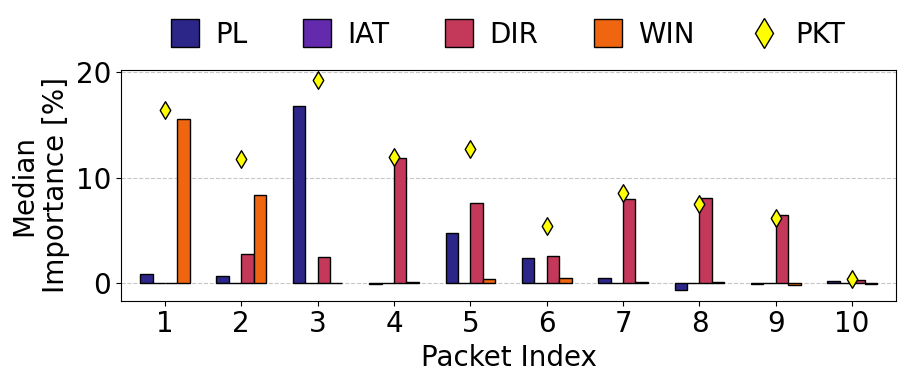

In [55]:
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(10,3))
bic_sum = np.sum(np.reshape(np.median(bic, axis=0)*100,(10,4)),axis=1)
df=pd.DataFrame(data=np.reshape(np.median(bic, axis=0)*100,(10,4)), columns=['PL', 'IAT', 'DIR', 'WIN'])
df.plot.bar(edgecolor='black', width=0.65, ax=axes, legend=False, color=sn.color_palette('CMRmap'))
axes.legend(bbox_to_anchor= (0.89, 2.45, 0., 0.), ncols=4, frameon=False, handlelength=1.2)
axes.set_xlabel('Packet Index')
axes.set_xticklabels([str(x+1) for x in np.arange(10)], rotation=0)
axes.scatter(np.arange(10),bic_sum, color='yellow', s=80, marker='d', edgecolor='black')
axes.grid(axis='y', linestyle='--', alpha=0.7)
axes.set_axisbelow(True)
axes.set_ylabel(r'Median' + '\n' + 'Importance [%]')

legend_elements = [Line2D([0], [0], marker='s', color='w', label='PL',
                          markerfacecolor=sn.color_palette('CMRmap')[0], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='IAT',
                          markerfacecolor=sn.color_palette('CMRmap')[1], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='DIR',
                          markerfacecolor=sn.color_palette('CMRmap')[2], markersize=20, markeredgecolor='black'),
                   Line2D([0], [0], marker='s', color='w', label='WIN',
                          markerfacecolor=sn.color_palette('CMRmap')[3], markersize=20, markeredgecolor='black'),
                  Line2D([0], [0], marker='d', color='w', label='PKT',
                          markerfacecolor='yellow', markersize=15, markeredgecolor='black')]

plt.legend(handles=legend_elements, ncol=5, bbox_to_anchor=(-0.01, 1.2, 1., -0.1), loc='center', columnspacing = 1.5,
          handletextpad=0.1, frameon=False)

plt.savefig(f'{outdir}/ransomware_confused_with_inj_http.pdf', dpi=300, bbox_inches='tight')